# Stratification (in MITgcm)
*Pressure, density, and buoyancy frequency in MITgcm*

Rowan Brown | 17.02.2025

I'm making this notebook as a reference for how to calculate pressure ($p$), density ($\rho$), and buoyancy frequency ($N^2$) from the MITgcm binary output.

But first, some necessary imports:

In [39]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm, SymLogNorm
from xmitgcm import open_mdsdataset 
from MITgcmutils import density
import basic_model_anayses as bma
import xgcm
import os

## Buoyancy frequency ($N^2$) and density ($\rho$)

Stratification can be generally expressed in terms of buoyancy frequency, 
$$
    N^2= - \frac{g}{\rho} \frac{\partial \rho(z)}{\partial z}.
$$

If: (1) we imagine that small excursions of a water parcel are taken *adiabatically*; (2) we use an equation of state defined by $\rho=\rho(S, \theta, p, p_r)$; and (3) **we have the coefficients of thermal and haline expansion, $\alpha$ and $\beta$**, then we can express buoyancy frequency exactly using 
$$
    N^2 = g \left(\alpha \theta_z - \beta S_z \right),
$$ 
where $S$ is (practical) salinity and $\theta$ is potential temperature. See Gill (1982; 50-54), McDougall (1987, Neutral...), and McDougall (1987, Thermobaricity...) for more detail. 

With MITgcm, it is therefore relatively simple, when using *eosType=LINEAR*, to calculate buoyancy frequency, because $\alpha$, $\beta$, and $\theta$ are given directly in either *data* or the model output. 

### Linear EOS

With the *eosType=LINEAR*, vertical gradients are not only determined by the output profiles, but also by the reference profiles, i.e.,
$$
    \rho = \rho_0 \left( 1 - \alpha \left( T(z) - T_{ref}(z) \right) + \beta \left( S(z)-S_{ref}(z) \right) \right),
$$
and if we let $\beta=0$ then
$$
    \frac{\partial \rho}{\partial z} = - \rho_0 \alpha \left( \frac{\partial T }{ \partial z} - \frac{\partial T_{ref} }{ \partial z} \right)
$$
(where $\rho_0$ is *I think* also specified in *data* and I *also* think $T$ in this case relates to potential temperature). Since the reference temperature profile is often invariant, its gradient is 0 and we can neglect this term when calculating gradients.

Note the reason I let $\beta=0$ is that, in some of the MITgcm test cases like "deep convection", *sBeta=0* and *saltStepping=False*. This works because, when *sBeta=0*, salinity does not affect the density gradient and so *saltStepping* can be turned on/off like a pasive tracer. In this case, buoyancy is therefore set up by potential temperature alone, i.e., $N^2=g \alpha \theta_z$, and it is simple to calculate.

### Non-linear EOS

In the case of a non-linear EOS, such as *eosType=TEOS10*, calculating density and buoyancy frequency are more tricky. The crux is how to calculate pressure. Martin explains the general theory nicely here http://mailman.mitgcm.org/pipermail/mitgcm-support/2016-August/010541.html. For simplicity, the linearised equation $\partial p/\partial z = -g \rho_0$ is usually adequate. But in my simulations, I use the diagnostic package to output enough data so that I can calculate the pressure during post-processing. Once we have pressure, if we're using the TEOS10 EOS, then we can use the Gibbs SeaWater (gsw) toolbox to calculate things like density and buoyancy frequency.

### Calculating pressure

To calculate pressure (with *Z*-coordinates; be careful that you don't also need to include another reference density in your equations like Jody Klymak uses here, http://mailman.mitgcm.org/pipermail/mitgcm-support/2013-November/008636.html, which I think relates to either p-coordinates or the anelastic case or some other edge case), use
$$
    P_{sea\ water}(i,j,k)/ \rho_0 = -g\ rC(k) + PH(i,j,k) + PNH(i,j,k),
$$
where where $rC(k)$ is the depth at level $k$, and the reference hydrostatic pressure is simply $-g\ rC(k)$. $PH(i,j,k)$ and $PNH(i,j,k)$ are directly from the model and relate to the *Hydrostatic Pressure Pot.(p/rho) Anomaly* and the *Non-Hydrostatic Pressure Pot.(p/rho)*. 

As noted above, Jody Klymak emphasizes that, for some edge cases with *eosType=LINEAR*, the hydrostatic pressure potential anomaly is
$$
    PH(i,j,k) \rho_0 = g \int_z^{\eta} \left( \rho(i,j,k) - \rho_r(k) \right) dz,
$$
where $\rho_r(k)$ is constant in depth if $T_{ref}$ is constant but varies if $T_{ref}$ is a profile. His point is that the hydrostatic pressure is therefore
$$
    P_{hydrostatic} (i,j,k) = PH(i,j,k) \rho_0 + g \int_z^{\eta} \left( \rho_0 + \rho_r(k) \right) dz.
$$
Ultimately, the difference between this equation and the hydrostatic part of the earlier $P_{sea\ water}$ equation is the additional $\rho_r(k)$ term, which is apparently removed from $PH$ in certain cases. He elaborates here: https://gist.github.com/jklymak/156c30b5344a9cf63e8aebc429fee1c6.

In general however, I believe we can simply use the earlier expression for $P_{sea\ water}(i,j,k)/ \rho_0$, which we can rearrange as
$$
    P = (PHIHYD + gravity*abs(RC))*rho_{const}
$$ 
(based on http://mailman.mitgcm.org/pipermail/mitgcm-support/2013-November/008636.html). 

## Calculating (hydrostatic) pressure with a non-linear EOS

(*Hydrostatic* because I can't seem to open $PNH$ 🙃...)

In [ ]:
# Load the data and constants
data_dir = '../MITgcm/so_plumes/mrb_023/' # This is an example run with eosType=TEOS10
ds = bma.open_mitgcm_output_all_vars(data_dir) # Open the dataset
g, rho_0 = 10, 1000 # Constants obtained from the mrb_023 data file

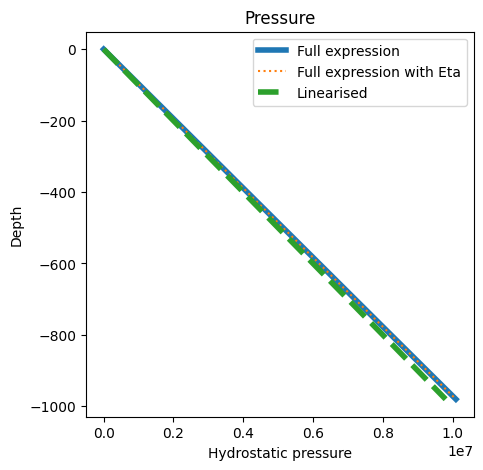

In [ ]:
# Calculations
ds['p_lin'] = (-1)*g*rho_0*ds['Z'] # Linearised hydrostatic pressure 
ds['p_PH'] = (-1)*g*rho_0*ds['Z'] + ds['PH']*rho_0 # Full hydrostatic pressure 
ds['p_PH_eta'] = (-1)*g*rho_0*(ds['Z']+ds['Eta']) + ds['PH']*rho_0 # Full hydrostatic pressure plus effects of changing SSH 
# (Note I found that PH likely includes the effects of a variable SSH so we shouldn't need to include it)

# Plotting
fig, ax = plt.subplots(figsize=(5,5)) # Initialise the figure
ds['p_PH'].isel(time=10,YC=50,XC=50).plot(y='Z',label='Full expression',ax=ax, lw=4)
ds['p_PH_eta'].isel(time=10,YC=50,XC=50).plot(y='Z',label='Full expression with Eta',ax=ax, ls=':')
ds['p_lin'].plot(y='Z',label='Linearised',ax=ax,lw=4, ls='--')
ax.set_title('Pressure')
ax.set_xlabel('Hydrostatic pressure')
ax.set_ylabel('Depth')
plt.legend()

## Calculating (hydrostatic) pressure with a linear EOS

In [42]:
# Loading the data
data_dir = '../MITgcm/so_plumes/mrb_011/' # This is an example run with eosType=TEOS10
ds = bma.open_mitgcm_output_all_vars(data_dir)
g, rho_0, alpha = 10, 1000, 0.0002, # From the data file

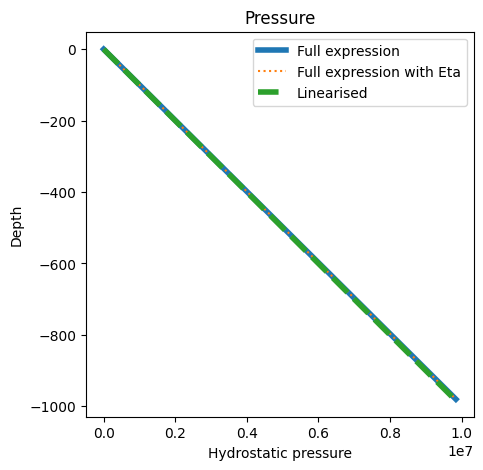

In [43]:
# Calculations
ds['p_lin'] = (-1)*g*rho_0*ds['Z']
ds['p_PH'] = (-1)*g*rho_0*ds['Z'] + ds['PH']*rho_0
ds['p_PH_eta'] = (-1)*g*rho_0*(ds['Z']+ds['Eta']) + ds['PH']*rho_0 # Full hydrostatic pressure 

# Plotting
fig, ax = plt.subplots(figsize=(5,5)) # Initialise the figure
ds['p_PH'].isel(time=10,YC=50,XC=50).plot(y='Z',label='Full expression',ax=ax, lw=4)
ds['p_PH_eta'].isel(time=10,YC=50,XC=50).plot(y='Z',label='Full expression with Eta',ax=ax, ls=':')
ds['p_lin'].plot(y='Z',label='Linearised',ax=ax,lw=4, ls='--')
ax.set_title('Pressure')
ax.set_xlabel('Hydrostatic pressure')
ax.set_ylabel('Depth')
plt.legend()